## Week 1: Working with time series

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def plot_series(time, series, format="-", title="", label=None, start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    if label:
        plt.legend()
    plt.grid(True)

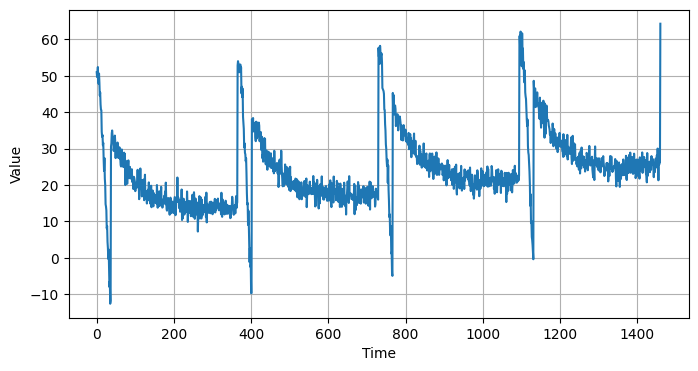

In [3]:
# The time dimension or the x-coordinate of the time series
TIME = np.arange(4 * 365 + 1, dtype="float32")

# Initial series is just a straight line with a y-intercept
y_intercept = 10
slope = 0.01
SERIES = trend(TIME, slope) + y_intercept

# Adding seasonality
amplitude = 40
SERIES += seasonality(TIME, period=365, amplitude=amplitude)

# Adding some noise
noise_level = 2
SERIES += noise(TIME, noise_level, seed=42)

# Plot the series
plt.figure(figsize=(8, 4))
plot_series(TIME, SERIES)
plt.show()

In [4]:
SPLIT_TIME = 1100

def train_val_split(time, series, time_step=SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

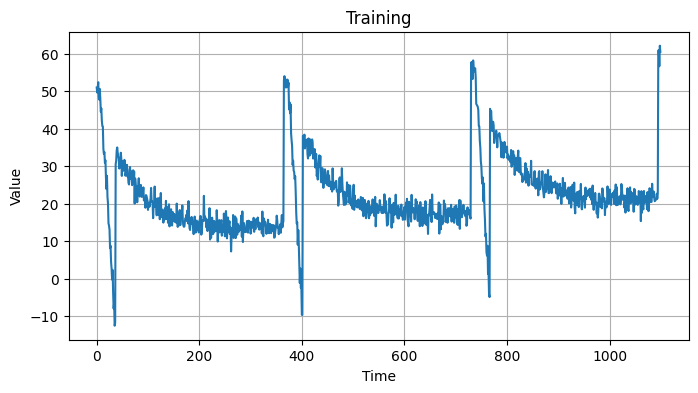

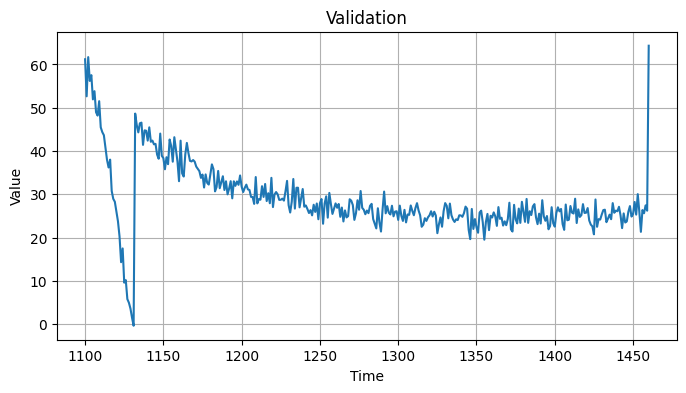

In [5]:
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

plt.figure(figsize=(8, 4))
plot_series(time_train, series_train, title="Training")
plt.show()

plt.figure(figsize=(8, 4))
plot_series(time_valid, series_valid, title="Validation")
plt.show()

In [6]:
def compute_metrics(true_series, forecast):
    
    mse = np.mean(np.square(true_series - forecast))
    mae = np.mean(np.abs(true_series - forecast))

    return mse, mae

### Naive Forecast

validation series has shape: (361,)
naive forecast has shape: (361,)
comparable with validation series: True


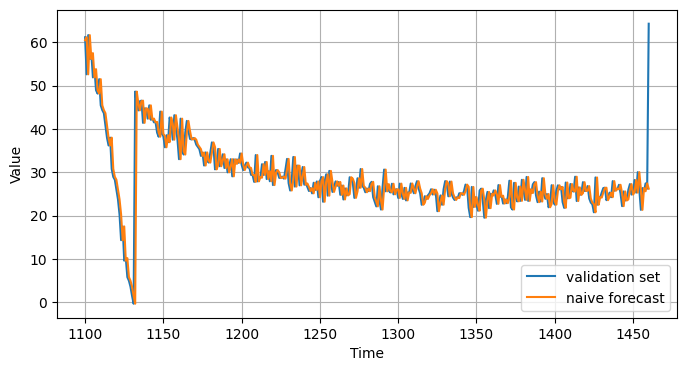

In [7]:
naive_forecast = SERIES[SPLIT_TIME - 1:][:-1]

print(f"validation series has shape: {series_valid.shape}")
print(f"naive forecast has shape: {naive_forecast.shape}")
print(f"comparable with validation series: {series_valid.shape == naive_forecast.shape}")

plt.figure(figsize=(8, 4))
plot_series(time_valid, series_valid, label="validation set")
plot_series(time_valid, naive_forecast, label="naive forecast")

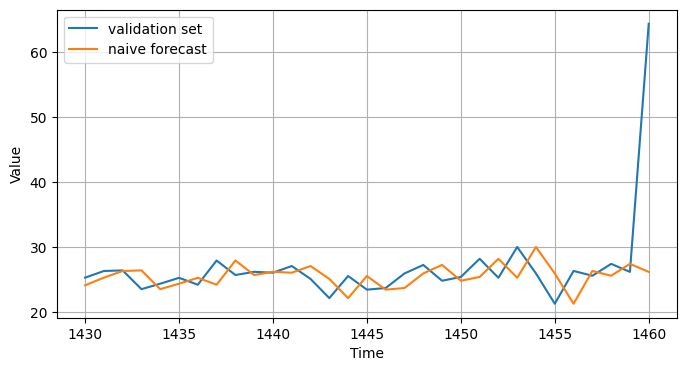

In [8]:
plt.figure(figsize=(8, 4))
plot_series(time_valid, series_valid, start=330, end=361, label="validation set")
plot_series(time_valid, naive_forecast, start=330, end=361, label="naive forecast")

In [9]:
mse, mae = compute_metrics(series_valid, naive_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for naive forecast")

mse: 19.58, mae: 2.60 for naive forecast


### Moving Average

In [10]:
def moving_average_forecast(series, window_size):
   
    forecast = []
    
    for time in range(len(series) - window_size):
        forecast.append(np.mean(series[time:time + window_size]))
        
    np_forecast = np.array(forecast)
    
    return np_forecast

In [11]:
print(f"Whole SERIES has {len(SERIES)} elements so the moving average forecast should have {len(SERIES)-30} elements")

Whole SERIES has 1461 elements so the moving average forecast should have 1431 elements


moving average forecast with whole SERIES has shape: (1431,)
moving average forecast after slicing has shape: (361,)
comparable with validation series: True


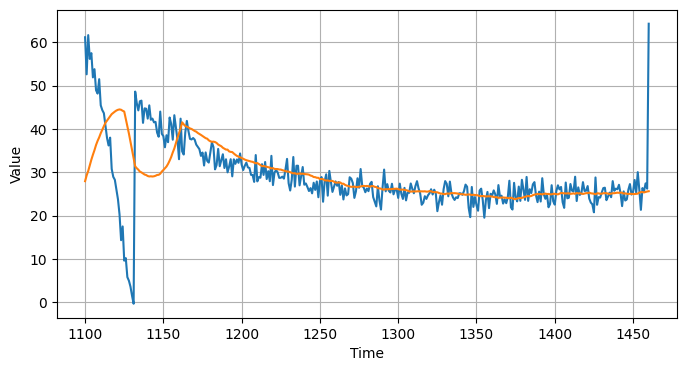

In [12]:
moving_avg = moving_average_forecast(SERIES, window_size=30)
print(f"moving average forecast with whole SERIES has shape: {moving_avg.shape}")

moving_avg = moving_avg[1100 - 30:]
print(f"moving average forecast after slicing has shape: {moving_avg.shape}")
print(f"comparable with validation series: {series_valid.shape == moving_avg.shape}")

plt.figure(figsize=(8, 4))
plot_series(time_valid, series_valid)
plot_series(time_valid, moving_avg)

In [13]:
mse, mae = compute_metrics(series_valid, moving_avg)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average forecast")

mse: 65.79, mae: 4.30 for moving average forecast


### Differencing

Whole SERIES has 1461 elements so the differencing should have 1096 elements


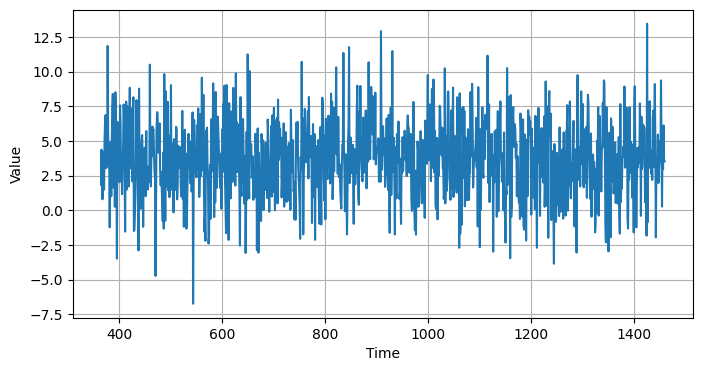

In [14]:
diff_series = SERIES[365:] - SERIES[:-365]
diff_time = TIME[365:]

print(f"Whole SERIES has {len(SERIES)} elements so the differencing should have {len(SERIES)-365} elements")

plt.figure(figsize=(8, 4))
plot_series(diff_time, diff_series)
plt.show()

moving average forecast with diff series has shape: (1046,)
moving average forecast with diff series after slicing has shape: (361,)


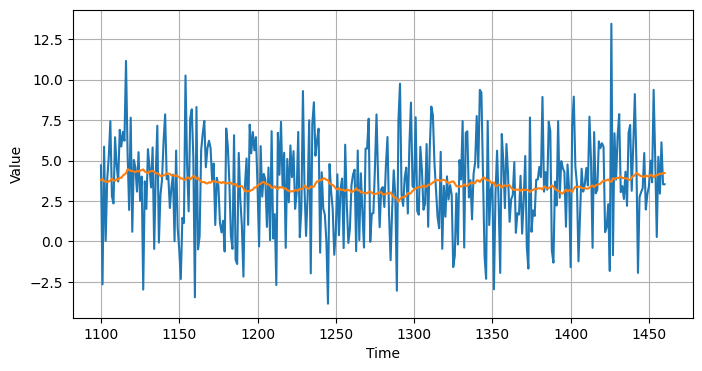

In [15]:
diff_moving_avg = moving_average_forecast(diff_series, 50)

print(f"moving average forecast with diff series has shape: {diff_moving_avg.shape}")

diff_moving_avg = diff_moving_avg[SPLIT_TIME - 365 - 50:]

print(f"moving average forecast with diff series after slicing has shape: {diff_moving_avg.shape}")


plt.figure(figsize=(8, 4))
plot_series(time_valid, diff_series[1100 - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

past series has shape: (361,)
moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True


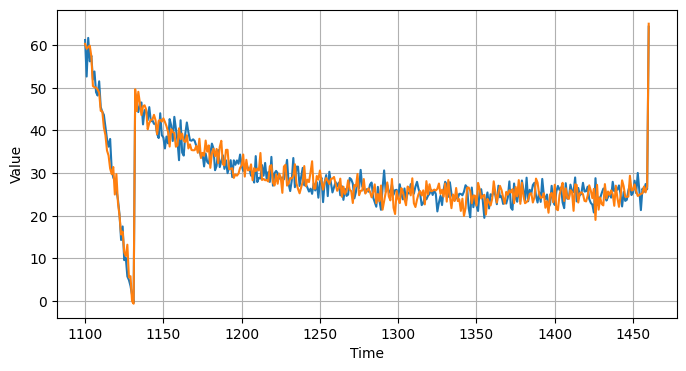

In [16]:
past_series = SERIES[SPLIT_TIME - 365:-365]

print(f"past series has shape: {past_series.shape}")

diff_moving_avg_plus_past = past_series + diff_moving_avg

print(f"moving average forecast with diff series plus past has shape: {diff_moving_avg_plus_past.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg_plus_past.shape}")

plt.figure(figsize=(8, 4))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [17]:
mse, mae = compute_metrics(series_valid, diff_moving_avg_plus_past)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus past forecast")

mse: 8.50, mae: 2.33 for moving average plus past forecast


smooth past series has shape: (361,)

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True


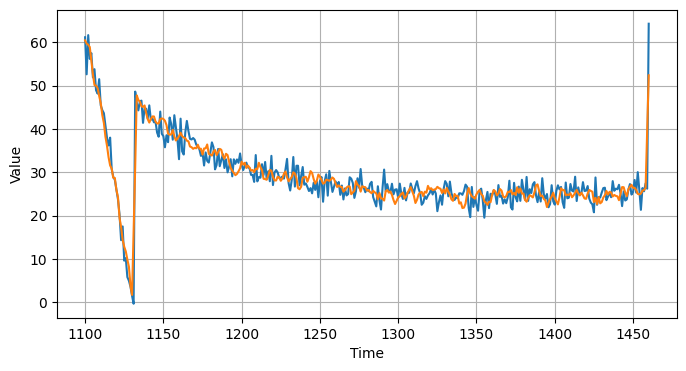

In [18]:
smooth_past_series = moving_average_forecast(SERIES[SPLIT_TIME - 365-1:-365+2], 3)

print(f"smooth past series has shape: {smooth_past_series.shape}\n")

# Add the smoothed out past values to the moving avg of diff series
diff_moving_avg_plus_smooth_past = smooth_past_series + diff_moving_avg

print(f"moving average forecast with diff series plus past has shape: {diff_moving_avg_plus_smooth_past.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg_plus_smooth_past.shape}")

plt.figure(figsize=(8, 4))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [19]:
mse, mae = compute_metrics(series_valid, diff_moving_avg_plus_smooth_past)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus smooth past forecast")

mse: 8.20, mae: 2.08 for moving average plus smooth past forecast
